# Detecção de Eventos Musicais e Andamento

## Objetivo
Ao fim desta unidade, o aluno será capaz de **aplicar** algoritmos para a detecção de eventos musicais utilizando a biblioteca PyMIR3.


## Pré-requisitos
Até o momento, sabemos que alguns eventos musicais, como notas, podem ser considerados estacionários em pequenos intervalos de tempo. Também, conhecemos alguns possíveis descritores que podem ser utilizados para caracterizar pequenos trechos de áudio.

## Eventos
Eventos musicais podem ter diversas naturezas. Notas musicais são muito comuns na música anterior ao século XX - inclusive, notas produzidas por instrumentos bastante específico. Especialmente depois da introdução da eletrônica na música, a variedade de timbres existentes aumentou bastante.

Eventos musicais são, também, caracterizados pelo sinal transiente que ocorre quando começam. Quando um arco começa a arranhar a corda de um violino, por exemplo, há um período transiente que precede a existência de uma nota harmônica. O mesmo ocorre quando o martelo toca uma corda de piano: antes que a corda vibre em todos os seus modos próprios, o som da martelada prevalece sobre os demais. Por fim, podemos pensar no som de um tambor; nesse caso, o som da baqueta batendo na pele é bastante evidente e quase não há ressonância harmônica.

Assim, podemos encontrar três categorias de sons, caracterizados pelo tipo de som (pitched / non-pitched) e pela sua característica transiente (percussive / non-percussive).

| Categoria | Exemplos |
| --- | --- |
| Pitched Non-Percussive | Violino, saxofone |
| Pitched Percussive | Piano, Marimba |
| Non-pitched Percussive | Tambor, pratos |


Eventos **percussivos** são aqueles cujo som se aproxima de um tambor. Podemos enumerar algumas características desse tipo de evento:
1. É compacto no tempo;
1. Se associa a um crescimento rápido da intensidade perceptual de áudio
1. Costuma se destacar rapidamente em um ambiente ruidoso

Se pensarmos em termos de quadros curtos de análise, faz sentido pensar que o quadro em que ocorre um evento percussiveo terá mais energia que o quadro anterior. Desta forma, poderíamos calcular a energia em cada quadro e então observar o seu comportameto. Temos, daí:

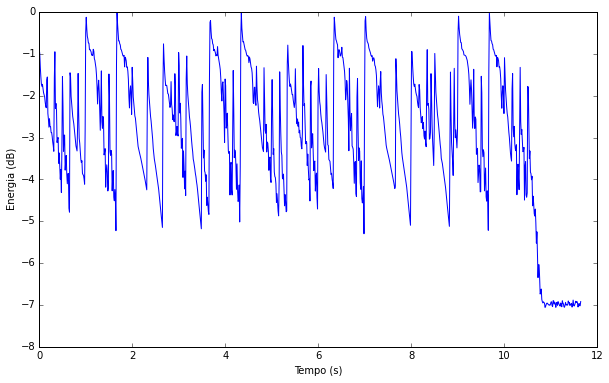

In [85]:
%matplotlib inline
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import IPython.lib.display as display 

import mir3.modules.tool.wav2spectrogram as spec
import mir3.modules.features.energy as energy

fname = 'audio/tabla.wav'
wav2spec = spec.Wav2Spectrogram() # Objeto que converte arquivos wav para espectrogramas
s = wav2spec.convert(open(fname, 'rb'), window_length=1024, window_step=512, spectrum_type='magnitude')

en = energy.Energy()
f = en.calc_track(s)
T = f.metadata.sampling_configuration.ofs

t = np.linspace(0, len(f.data)/T, len(f.data))

plt.figure(figsize=(10, 6))
plt.plot(t, np.log10(f.data/np.max(f.data)))
plt.xlabel('Tempo (s)')
plt.ylabel('Energia (dB)')
plt.show()

display.Audio(fname)

O que verificamos nesta imagem é que a energia relacionada a um evento decai exponencialmente. Durante o decaimento, ela pode ocultar o crescimento de energia relacionado a outros eventos. Isso pode prejudicar nosso processo de detecção.

Uma outra característica que pode ser usada para detectar eventos percussivos é o fato de que um evento percussivo é compacto no tempo. Isso significa que ele ocorre durante um período bastante curto de tempo e, portanto, se assemelha a um impulso. Portanto, carrega conteúdo espectral em todas as frequências. Eventos percussivos são, em geral, audíveis

Desta forma, podemos pensar numa característica de um quadro chamada *fluxo espectral*. Trata-se da **soma da diferença positiva entre a magnitude de um quadro e do quadro anterior**, ou:
$$f_q = \sum_{k=0}^{K-1} |X_q[k]| - |X_{q-1}[k]|.$$

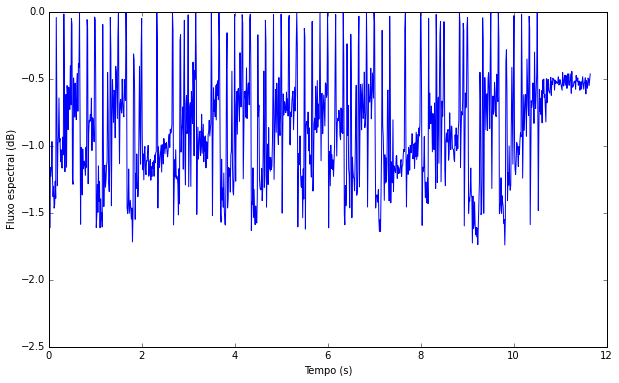

In [86]:
import mir3.modules.features.flux as flux
fname = 'audio/tabla.wav'
wav2spec = spec.Wav2Spectrogram() # Objeto que converte arquivos wav para espectrogramas
s = wav2spec.convert(open(fname, 'rb'), window_length=1024, window_step=512, spectrum_type='magnitude')

fx = flux.Flux()
f = fx.calc_track(s)
T = f.metadata.sampling_configuration.ofs

t = np.linspace(0, len(f.data)/float(T), len(f.data))

f.data += 10**(-2) # Isto evita divisoes por zero ao calcular o log10 a seguir 
plt.figure(figsize=(10, 6))
plt.plot(t, np.log10(f.data/np.max(f.data)))
plt.xlabel('Tempo (s)')
plt.ylabel('Fluxo espectral (dB)')
plt.show()

display.Audio(fname)

## Detecção

Vemos um fenômeno interessante, desta vez. As batidas principais (correspondentes aos *upbeats*) estão bem marcadas, mas ainda assim temos uma certa dificuldade em visualizar as batidas correspondentes às batidas mais fracas. Mesmo assim, este processo já permite encontrar um algoritmo para detecção de *onsets*, que parte da idéia de que todo pico do fluxo espectral acima do limiar $-0.5$ dB deve corresponder a um evento:

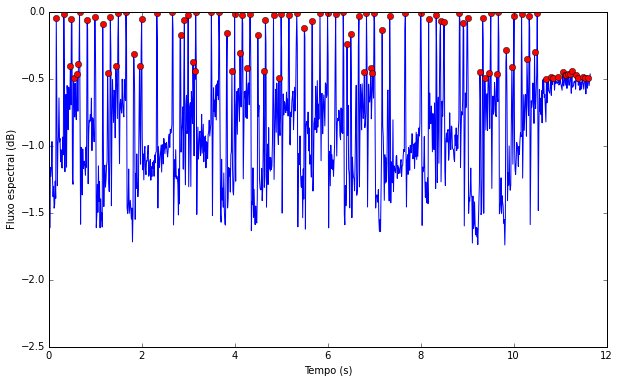

In [94]:
h = np.log10(f.data/np.max(f.data))
tg = []
g = []
for i in xrange(len(h)-2):
    if (h[i+1] > h[i]) and (h[i+1] > h[i+2]): # Condicao 1: eh um pico
        if (h[i+1] > -.5): # Condicao 2: magnitude acima de um limiar
            g.append(h[i+1])
            tg.append(t[i+1])

plt.figure(figsize=(10, 6))
plt.plot(t, h)
plt.plot(tg, g, 'ro')
plt.xlabel('Tempo (s)')
plt.ylabel('Fluxo espectral (dB)')
plt.show()

Podemos verificar que a estimativa de limiar em $-0.5$ dB gerou alguns resultados inesperados. Podemos variar esse limiar e verificar como ele está ligado à sensibilidade do sistema de detecção.

## Avaliação

Verificamos diversas versões do nosso sistema de detecção de onsets. Porém, precisamos de, de alguma forma, avaliar *objetivamente* sua acurácea.

Há dois fatores a serem levados em consideração. Gostaríamos que nosso sistema encontrasse muitos dos *onsets* contidos em nosso trecho de áudio. Para medir isso, usamos um gabarito (*ground truth*) e a medida Recall:
$$ R = \frac{\mbox{# acertos}}{\mbox {# elementos no gabarito}}.$$

Por outro lado, poderíamos criar um sistema que aponta onsets em TODOS os quadros de análise, e isso não seria muito útil, embora gere um Recall de 100%. Para levar em consideração o grande número de falsos positivos encontrados, usamos a medida Precision:
$$ P = \frac{\mbox{# acertos}}{\mbox {# hipóteses geradas}}.$$

Recall é uma medida ligada aos falsos negativos apresentados pelo sistema. Precision é uma medida ligada aos falsos positivos. Para combiná-las, utilizamos a medida F-Measure, que é a média harmônica de $R$ e $P$:
$$F = 2\frac{RP}{R+P}.$$

Nos resta, então, uma questão filosófica: o que significa *acertar* uma estimativa? O sistema que criamos tem precisão finita no tempo, já que estamos lidando com análise quadro-a-quadro. Isso quer dizer que precisamos definir uma precisão "aceitável" para nosso sistema. Essa precisão depende da aplicação que queremos. Podemos relacionar tempos de atraso a alguns eventos típicos:

| Precisão ($\pm x$ ms) | Exemplos de atraso |
| --- | --- |
| 0 | Precisão absoluta. Impossível mesmo para seres humanos. |
| 1 | Atraso muito pequeno, mesmo para uma placa de som (64 amostras a 44100 Hz) |
| 5 | Tempo entre o início de dois quadros de análise (256 amostras a 44100 Hz) |
| 5 a 10 | Atraso começa a ser perceptível, dependendo do tipo de evento |
| 11 | Tempo entre o início de dois quadros de análise (512 amostras a 44100 Hz) |
| 10 a 20 | Atraso começa a incomodar as possibilidades musicais |
| 20 a 50 | Atraso incomoda consideravelmente |
| 200 a 500 | Tempo de resposta de um ser humano |

Nas comunidades acadêmicas, é comum definir uma tolerância típica, que leva em consideração a natureza dos sistemas desenvolvidos. A comunidade MIR, no evento [MIREX](http://www.music-ir.org/mirex/wiki/2015:Audio_Onset_Detection), usa uma tolerância de $\pm 50$ ms.

## Andamento (BPM)

A tabela de atrasos logo acima mostra um fenômeno interessante. Um atraso de 20 a 50 ms já incomoda consideravelmente o músico, no sentido de se tornar pouco musical; por outro lado, o tempo de reação de um ser humano varia de 200 a 500 ms (dependendo do ser humano).

**Então, como é possível que dois músicos improvisem juntos? Ou ainda, como é possível que duas pessoas dancem juntas, especialmente danças de salão em par, nas quais não há uma coreografia previamente definida?**

Essa possibilidade só existe porque seres humanos são capazes de *antecipar eventos*. Trata-se de uma habilidade humana bastante relacionada com sentimentos como expectativa e frustração. Essa habilidade só é possível porque há padrões em certos fenômenos.

No contexto de música (considerando a música popular que surgiu à partir da música da Europa ocidental pré-século XIX), um importante padrão de comportamento é o *andamento* (em italiano: *tempo*). Ele é geralmente definido como a taxa em que uma pessoa move a cabeça ou bate os pés ao ouvir uma música. Essa definição não é muito precisa em termos matemáticos, mas a própria noção de *andamento* é bastante controversa.

Em verdade, o andamento é uma percepção que emerge à partir da organização temporal dos elementos de uma música. Em se tratando de uma percepção, pode variar de pessoa para pessoa. Em alguns casos, a organização dos elementos musicais nem mesmo emerge: algumas músicas não seguem nenhum *andamento*.

A percepção de andamento está ligada à repetição de eventos na escala de segundos. Assim, é possível considerar que o andamento está para os eventos sonoros assim como a *altura* está para a vibração da pressão do ar. Portanto, é possível usar o algoritmo de autocorrelação para determinar o *andamento* de um determinado trecho, usando como entrada uma função que evidencie *onsets*, tal como o fluxo espectral:

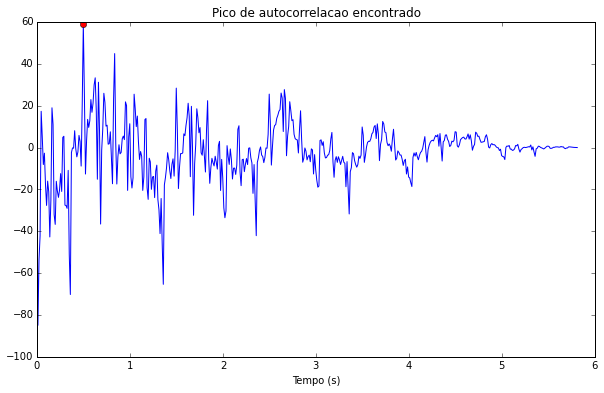

Andamento:  120.065493925 BPM


In [90]:
def t0_acc(x):
    """Retorna o periodo fundamental de x, em amostras"""
    X = np.abs(np.fft.fft(x))
    r = np.real(np.fft.ifft(X*X))
    r2 = np.zeros(len(r)/2)
    for n in xrange(len(r2)):
        r2[n] = r[n]-r[n/2]
    r2 *= np.linspace(1, 0, len(r2))
    t0 = np.argmax(r2)
    return t0, r, r2


t0,r,r2 = t0_acc(h) # T0 em amostras

#plt.plot(t[0:len(r2)],h[0:len(r2)])
#plt.show()
#plt.plot(t[0:len(r2)],r[0:len(r2)])
#plt.show()
plt.figure(figsize=(10, 6))
plt.plot(t[0:len(r2)], r2)
plt.plot(t[t0], r2[t0], 'ro')
plt.title('Pico de autocorrelacao encontrado')
plt.xlabel('Tempo (s)')
plt.show()
f0 = 1/float(t[t0]) # f0 em Hz
bpm = f0 * 60
print "Andamento: ", bpm, "BPM"


Ao aplicar o algoritmo de autocorrelação para encontrar andamentos, assim como no caso de encontrar alturas, estamos sujeitos a erros do tipo dobro ou metade. Esses erros costumam ser mais "perdoáveis" que outros erros, porque andamentos dobrados são comuns na música ocidental (inclusive como técnica de composição).

## Exercícios
1. Execute a detecção de eventos musicais e de andamento utilizando algum outro trecho de áudio, mas que contenha onsets não-percussivos. Qual é o comportamento dos algoritmos, nesse caso?

1. A técnica de detecção de eventos musicais usando limiar depende, claro, da definição do limiar de detecção que será aplicado sobre uma função de detecção de eventos (tal como a energia ou o fluxo espectral). O que podemos esperar que aconteça com as métricas de desempenho Recall e Precision caso o limiar de detecção seja aumentado ou diminuído? As métricas aumentam ou diminuem? Por que?

1. Quando detectamos uma curva de alturas ao longo de um sinal sonoro, dividimos o sinal em pequenos quadros, dentro dos quais assumimos que a altura permanece constante. Após, calculamos a altura para cada quadro. Como seria possível calcular uma curva de andamentos para uma performance musical bastante expressiva, na qual o andamento muda muito?

1. Qual é a duração (em segundos) do menor trecho de áudio possível que deve ser observado para determinar, através do algoritmo de autocorrelação, um andamento de 120 BPM? Justifique.

1. É possível implementar um algoritmo de detecção de eventos musicais para que opere em tempo real? Justifique, mostrando como o algoritmo funciona ou mostrando a etapa que não pode ser executada em tempo real.
